<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/Shakespeare_LM_v5_Causal_Mask_%2B_Customized_Transformer_%2B_subword_tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
USE_GPU = True

BLOCK_SIZE = 96 # Context length: how many chars do we take to predict the next one?

# Setup GPU

In [37]:
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  assert device.type != 'cpu', "GPU is not available"
else:
  device = 'cpu'

print(device)

cuda:0


In [38]:
g_cpu = torch.Generator(device='cpu').manual_seed(2147483647) # for reproducibility
g_device = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# Util Functions

# Load data

In [39]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read in all the words
text = open('input.txt', 'r').read()

text[:800]

--2023-10-03 05:58:05--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-10-03 05:58:05 (19.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to p"

In [40]:
print(f'total char # = {len(text)}')

total char # = 1115394


# Setup tokenizer

In [41]:
# Setup tokenizer

!pip install tokenizers # Since we are running in colab docker image, install it here.
# See https://anaconda.org/conda-forge/tokenizers
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_pretrained("bert-base-cased")

In [42]:
test = tokenizer.encode("I can feel the magic, can you, what's that bro?")

test.ids, test.type_ids, test.tokens, test.offsets

# testto

([101,
  146,
  1169,
  1631,
  1103,
  3974,
  117,
  1169,
  1128,
  117,
  1184,
  112,
  188,
  1115,
  9304,
  1186,
  136,
  102],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['[CLS]',
  'I',
  'can',
  'feel',
  'the',
  'magic',
  ',',
  'can',
  'you',
  ',',
  'what',
  "'",
  's',
  'that',
  'br',
  '##o',
  '?',
  '[SEP]'],
 [(0, 0),
  (0, 1),
  (2, 5),
  (6, 10),
  (11, 14),
  (15, 20),
  (20, 21),
  (22, 25),
  (26, 29),
  (29, 30),
  (31, 35),
  (35, 36),
  (36, 37),
  (38, 42),
  (43, 45),
  (45, 46),
  (46, 47),
  (0, 0)])

In [43]:
vocab_size = tokenizer.get_vocab_size()
print(f'{vocab_size=}')

vocab_size=28996


In [44]:
# str ---> list of integer
# encode = tokenizer.encode
encode = lambda str: tokenizer.encode(str).ids

# list of integer ---> str
decode = tokenizer.decode

_test_str = "adb dfd \nplace"

# TODO: this fails  because the tokenizer's encoding result doesn't include "\n"
# assert _test_str == decode(encode(_test_str).ids)

# Create DS

In [45]:
n1 = int(len(text) * 0.9)
train_data = encode(text[:n1])
dev_data = encode(text[n1:])

print(f'{len(train_data)=}, {len(dev_data)=}')

len(train_data)=283186, len(dev_data)=33357


In [46]:
def get_batch(data, batch_size: int, block_size: int):
  """ Sample a batch using Causal style. """
  x_list = []
  y_list = []
  ix = torch.randint(0, len(data)-block_size, (batch_size,), generator=g_cpu)
  X = torch.stack([torch.tensor(data[i:i+block_size]) for i in ix]).to(device)
  Y = torch.stack([torch.tensor(data[i+1:i+1+block_size]) for i in ix]).to(device)
  return X, Y

In [47]:
X, Y = get_batch(train_data, 16, BLOCK_SIZE)

for b in range(3):
  it = 0
  for t in range(X.shape[1]):
    print(f'{decode(X[b, :t+1].tolist())} ---> {decode([Y[b, t].item()])}')
    it += 1
    if it > 7:
      break

King ---> .
King. ---> '
King. ' ---> My
King. ' My ---> dangerous
King. ' My dangerous ---> cousin
King. ' My dangerous cousin ---> ,
King. ' My dangerous cousin, ---> let
King. ' My dangerous cousin, let ---> your
dear ---> dear
dear dear ---> lord
dear dear lord ---> ,
dear dear lord, ---> The
dear dear lord, The ---> pure
dear dear lord, The pure ---> ##st
dear dear lord, The purest ---> treasure
dear dear lord, The purest treasure ---> mortal
as ---> I
as I ---> guess
as I guess ---> ,
as I guess, ---> To
as I guess, To ---> make
as I guess, To make ---> a
as I guess, To make a ---> bloody
as I guess, To make a bloody ---> supper


# Modeling

In [48]:
n_embd = 768 # the dimensionality of the character embedding vectors
d_head = 2 * n_embd # the dim of the transformer's head
N_HIDDEN = n_embd * 4 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

## Model class

In [49]:
class LayerNorm(torch.nn.Module):
  """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

  def __init__(self, ndim: int, bias: bool):
    super().__init__()
    self.weight = torch.nn.Parameter(torch.ones(ndim))
    self.bias = torch.nn.Parameter(torch.zeros(ndim)) if bias else None

  def forward(self, x):
    return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

In [55]:
class AttentionBlock(torch.nn.Module):

  def __init__(self, vocab_size, d_in, d_hidden, d_head):
    """
    Args:
      vocab_size: volabulary size
      d_in: dim of input. If this is the immediate next layer of the token
        embedding layer, this is the dim of the embedding for a token.
      d_hidden: dim of hidden FFN layers
      d_head: dim of the transformer head
    """
    super().__init__()

    self.d_head = d_head
    self.key1 = torch.nn.Linear(d_in, d_head, bias=False)
    self.query1 = torch.nn.Linear(d_in, d_head, bias=False)
    self.value1 = torch.nn.Linear(d_in, d_head, bias=False)

    self.linear1 = torch.nn.Linear(d_head, d_hidden, bias=True)
    self.tanh1 = torch.nn.Tanh()
    # Project d_hidden back to d_head as output
    self.proj = torch.nn.Linear(d_hidden, d_head, bias=True)

    self.ln1 = LayerNorm(d_in, bias=True)
    self.ln2 = LayerNorm(d_head, bias=True)

  def forward(self, x):
    """
    Args:
      x: (B, T, C). The input to the model.
    Returns:
      loss: int
      logits: (B, T, C)
    """

    T = x.shape[-2]
    tril = torch.tril(torch.ones(T, T)).to(device)

    x = self.ln1(x)

    k = self.key1(x)  # (B, T, d_head)
    q = self.query1(x) # (B, T, d_head)
    wei = k @ q.transpose(-2, -1) # (B, T, d_head) @ (B, d_head, T) = (B, T, T)
    wei = wei.masked_fill(tril==0, -float('inf')) # (B, T, T)
    wei = wei * self.d_head**-0.5
    wei = F.softmax(wei, dim=-1) # (B, T, T)

    v = self.value1(x) # (B, T, d_head)
    # This makes the y[:,t,:], to have the information of the embedding (v)
    # v[:, u (u<=t), :], but not have the infomration of v[:, w (w>t), :]
    #
    # 1. Spread v's information at all t to y[:, any t, :]
    #
    # Because v is on rhs of @, its information at different T are spread out to
    # the different T in y
    #
    # Think about (T, T) @ (T, d_head) = (T, d_head)
    #
    # a11, a12     b1   a11*b1+a12*b2
    # a21, a22  @  b2 = a21*b1+a22*b2
    #
    # In the result, at T=1, it has b1 and b2, which are the rhs of @'s info at
    # different T
    #
    # 2. Limit y[:, t, :] to not access v[:, w (w>t), :].
    #
    # This is done by `tril`
    y = wei @ v # (B, T, d_head)

    y = self.ln2(y)

    # It doesn't need tril here, because the lhs and rhs doesn't exchange
    # information at different T.
    #
    # Let's say:
    # - input is y (B, T, d_head)
    # - Linear(d_in, d_out) is a matrix l(d_in, d_out), here dim is l(d_head, d_hidden)
    # - result is z (B, T, d_hidden)
    #
    # linear(y) = y @ l = z
    #
    # To simplify, ignore B, T=3, d_head=2, d_hidden=1
    #
    #         y11 y12         y11*l1+y12*l2
    # y @ l = y21 y22 @ l1  = y21*l1+y22*l2
    #         y31 y32   l2    y31*l1+y32*l2
    #
    # We can see z[:, T, :] only contains y[:, T, :]'s info
    #
    # To summarize this and the previous section
    #
    # Z = X @ Y
    #
    # Z[T, :] only contains X[T, :]'s info, doesn't contain X[S != T, :]'s infor
    # Z[T, :] contains Y[at any index, :]'s info
    y = self.linear1(y) # (B, T, d_hidden)
    y = self.tanh1(y) # (B, T, d_hidden)
    y = self.proj(y) # (B, T, d_head)

    return y

  def generate(self, idx, max_new_tokens: int):
    """Generate new tokens given idx as context.

    Args:
      idx: (B, T)
      max_new_tokens: number of new tokens to generate

    Returns:
      (B,T+max_new_tokens)
    """
    for _ in range(max_new_tokens):
      logits, loss = self(idx, targets=None)  # logits: (B, T, vocab_size), loss: None
      logits = logits[:, -1, :] # (B, vocab_size)
      prob = F.softmax(logits, dim=1) # (B, vocab_size)
      idx_next = torch.multinomial(prob, num_samples=1, replacement=False)  # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [65]:
class Net(torch.nn.Module):

  def __init__(self, vocab_size, d_embd, d_hidden, d_head):
    """
    Args:
      vocab_size: volabulary size
      d_embd: dim of embedding for the token
      d_hidden: dim of hidden FFN layers
      d_head: dim of the transformer head
    """
    super().__init__()

    self.d_head = d_head

    self.embd = torch.nn.Embedding(
        num_embeddings=vocab_size,
        embedding_dim=d_embd
    )
    self.attn1 = AttentionBlock(vocab_size, d_embd, d_hidden, d_head)
    self.attn2 = AttentionBlock(vocab_size, d_head, d_hidden, d_head)
    self.linear_logit = torch.nn.Linear(d_head, vocab_size, bias=True)


  def forward(self, x, targets=None):
    """
    Args:
      x: (B, T). The input to the model.
      targets: (B, T). When it is not None, the func calculates and return the
        loss in additional to other returned item(s)
    Returns:
      loss: int
      logits: (B, T, C)
    """

    T = x.shape[-1]
    tril = torch.tril(torch.ones(T, T)).to(device)

    xemb = self.embd(x) # (B, T, C)

    y = self.attn1(xemb)
    y = self.attn2(y)

    logits = self.linear_logit(y) # (B, T, vocab_size)
    logits = logits.view(-1, logits.shape[-1]) # (B, T, vocab_size)

    if targets is None:
      loss = None
    else:
      loss = F.cross_entropy(logits, targets.view(-1))

    return logits.view(-1, T, logits.shape[1]), loss

  def generate(self, idx, max_new_tokens: int):
    """Generate new tokens given idx as context.

    Args:
      idx: (B, T)
      max_new_tokens: number of new tokens to generate

    Returns:
      (B, T+max_new_tokens)
    """
    for _ in range(max_new_tokens):
      logits, loss = self(idx, targets=None)  # logits: (B, T, vocab_size), loss: None
      logits = logits[:, -1, :] # (B, vocab_size)
      prob = F.softmax(logits, dim=1) # (B, vocab_size)
      idx_next = torch.multinomial(prob, num_samples=1, replacement=False)  # (B, 1)
      idx = torch.cat((idx, idx_next), dim=1)

    return idx

net = Net(vocab_size, d_embd=n_embd, d_hidden=N_HIDDEN, d_head=N_HIDDEN).to(device)

In [66]:
_total_params = 0

for p in net.parameters():
  _total_params += p.nelement()

print(f'Total params = {_total_params}')

Total params = 184544068


## Define optimizer

In [67]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train

In [68]:
max_steps = 700000
batch_size = 16
lossi = []
lossi_dev = []
ud = []
log_interval = 50

running_loss = 0.0
running_loss_dev = 0.0
running_loss_steps = 0

for i in range(max_steps):

  # Forward
  Xb, Yb = get_batch(train_data, batch_size, BLOCK_SIZE)
  optimizer.zero_grad()
  logits, loss = net(Xb, targets=Yb)

  # Loss
  # print(f'{outputs.shape=}, {Yb.shape=}')
  running_loss += loss.item()
  running_loss_steps += 1

  # Eval dev DS
  Xb_dev, Yb_dev = get_batch(dev_data, batch_size, BLOCK_SIZE)
  logits_dev, loss_dev = net(Xb_dev, targets=Yb_dev)
  running_loss_dev += loss_dev.item()

  # Update
  loss.backward()
  optimizer.step()

  # Track status
  if i % log_interval == 0:
    print(f'{i}/{max_steps}: training loss={running_loss/running_loss_steps:.4f}, dev loss={running_loss_dev/running_loss_steps:.4f}')
    running_loss = 0.0
    running_loss_dev = 0.0
    running_loss_steps = 0

  lossi.append(loss.log10().item())
  lossi_dev.append(loss_dev.log10().item())

0/700000: training loss=10.2902, dev loss=10.2917
50/700000: training loss=9.7995, dev loss=9.7726
100/700000: training loss=8.3527, dev loss=8.3291
150/700000: training loss=7.6600, dev loss=7.6613
200/700000: training loss=7.3409, dev loss=7.3684
250/700000: training loss=7.1840, dev loss=7.2077
300/700000: training loss=7.0567, dev loss=7.1158
350/700000: training loss=6.9703, dev loss=7.0544
400/700000: training loss=6.9225, dev loss=6.9978
450/700000: training loss=6.8799, dev loss=6.9878
500/700000: training loss=6.8334, dev loss=6.9570
550/700000: training loss=6.8332, dev loss=6.9249
600/700000: training loss=6.7843, dev loss=6.9130
650/700000: training loss=6.7752, dev loss=6.9110
700/700000: training loss=6.7817, dev loss=6.9145
750/700000: training loss=6.7390, dev loss=6.8784
800/700000: training loss=6.7367, dev loss=6.8474
850/700000: training loss=6.7394, dev loss=6.8709
900/700000: training loss=6.7267, dev loss=6.8415
950/700000: training loss=6.7043, dev loss=6.8407
1

KeyboardInterrupt: ignored

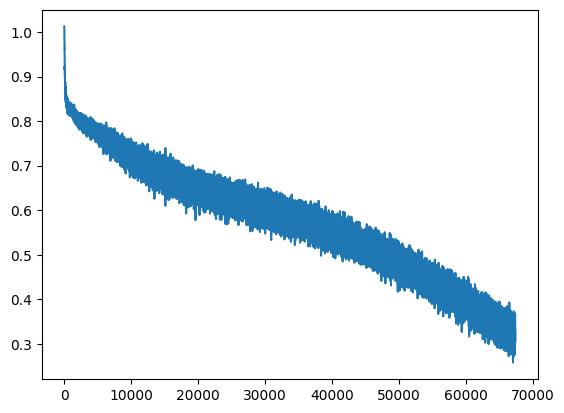

In [69]:
plt.plot(lossi)

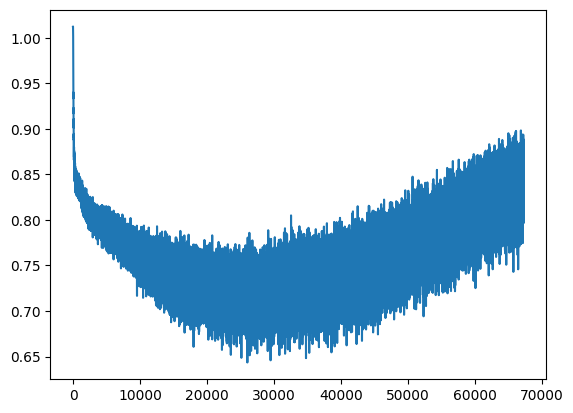

In [70]:
plt.plot(lossi_dev)

In [71]:
torch.cuda.empty_cache()

# Sample the model

In [72]:
g_gpu = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# 0, which is new line char, is a reasonable start (seed) char
idx = torch.tensor([[0]]).to(device)
new_idx = net.generate(idx, BLOCK_SIZE * 2)

print(decode(new_idx.view(-1).tolist()))

out of a restraint, EXT : Which triumph roared and not delivers thee : thou lies didst in a life, If I swear for I stood for thee will use to light, I beggarly proportion in a thing I looked fast my soul Be prey. HORTENSIO : And fear, And ne ' er - As pretty degree, Petruchio, I seize vengeance for me, As well - Both is my fault son Who brings makes This and by heaven, And she serve I was a woman Will he is banish ' Twas made the supreme me, As I would Be executed ' s weapon, I am the crown About a time in great does or say well my lips in a bless lamenta of my life be j adjoining is my brother eye - Both ' such vanity, As I heard it is the bless tears little divine, or two And blow, That know the poor execution Of said. As little
